# 지성민님 코드 필사 및 스터디

github folder

# import

In [1]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 기본
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# from sklearn.externals import joblib 
from sklearn.metrics import make_scorer

# 시계열
# from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Deep Neural Network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

# 설정
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format

# Evaluate Metric
- MAE(Mean Absolute Error) : 절대값 오차의 평균
- validation을 위한 함수 생성 및 make scorer

In [4]:
def mae(prediction, correct):
    prediction = np.array(prediction)
    correct = np.array(correct)
    
    difference = correct - prediction
    abs_val = abs(difference)
    
    score = abs_val.mean()
    
    return score

mae_scorer = make_scorer(mae)
mae_scorer

make_scorer(mae)

# ISSUE

1) 예측해야 하는 범위는 3개월인데 데이터는 시간 단위로 나뉘어져 있음
 - 월 단위로 resampling 후 forecast 범위를 3개월로 지정해야 해결


2) 1967개의 store_id가 각각 trend와 seasonality를 가지고 있음
 - 같은 알고리즘에서 각 store_id별로 parameter를 조절
  

3) 예측 날짜는 2019-03~2019-05로 동일하나, 제공 데이터의 마지막 날짜는 차이가 존재
 - 마지막 날짜부터 3개월만 예측하여 제출한다.(ex:store_id 111의 마지막 날짜는 2018-09월로 뒤 3개월인 2018-10~2018~12만 예측하여 제출)
 - 예측 기간이 길어질수록 오차가 크게 발생해 바로 뒤 3개월만 예측하는 것이 정확도가 높았음

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/dacon/[연습]상점 신용카드 매출 예측 경진대회/data/140472_store_credit_card_revenue_data/funda_train.csv')
df_sub = pd.read_csv('/content/drive/MyDrive/dacon/[연습]상점 신용카드 매출 예측 경진대회/data/140472_store_credit_card_revenue_data/submission.csv')


In [6]:
df_train.head()


,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.14286
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.14286
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.00000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.14286
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.00000


In [7]:
df_train.store_id.nunique()

1967

In [8]:
df_train.store_id.nunique()

1967

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


In [10]:
df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   store_id          int64         
 1   card_id           int64         
 2   card_company      object        
 3   transacted_date   datetime64[ns]
 4   transacted_time   object        
 5   installment_term  int64         
 6   region            object        
 7   type_of_business  object        
 8   amount            float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 450.2+ MB


In [11]:
print(df_train.shape)

(6556613, 9)


In [12]:
df_train.columns

Index(['store_id', 'card_id', 'card_company', 'transacted_date',
       'transacted_time', 'installment_term', 'region', 'type_of_business',
       'amount'],
      dtype='object')

In [13]:
frame_info = [(col, len(df_train[col].unique()), df_train[col].isnull().sum(), df_train[col].dtype, df_train[col].unique()[:5]) for col in df_train.columns]
df_info = pd.DataFrame(frame_info, columns=['name', 'num_of_unique', 'num_of_nan', 'type', 'front5_values'])

In [14]:
df_info

,name,num_of_unique,num_of_nan,type,front5_values
0,store_id,1967,0,int64,"[0, 1, 2, 4, 5]"
1,card_id,3950001,0,int64,"[0, 1, 2, 3, 4]"
2,card_company,8,0,object,"[b, h, c, a, f]"
3,transacted_date,1003,0,datetime64[ns],"[2016-06-01T00:00:00.000000000, 2016-06-02T00:..."
4,transacted_time,1440,0,object,"[13:13, 18:12, 18:52, 20:22, 11:06]"
5,installment_term,34,0,int64,"[0, 2, 3, 60, 4]"
6,region,181,2042766,object,"[nan, 서울 종로구, 충북 충주시, 부산 동래구, 경기 평택시]"
7,type_of_business,146,3952609,object,"[기타 미용업, nan, 의복 액세서리 및 모조 장신구 도매업, 한식 음식점업, 배..."
8,amount,30551,0,float64,"[1857.142857142857, 857.1428571428571, 2000.0,..."


### 시계열 분석을 위해 data 정보를 index로 변환

In [15]:
df_train = df_train.set_index('transacted_date')
df_train.head(3)

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.14286
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.14286
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.00000


### 시간 단위로 나뉘어져 있는 데이터를 일단위로 resampling
- 'store_id', 'region', 'type_of_business' 기존과 동일
- day_of_week : 각 요일을 나타내는 숫자, 월요일은 0 일요일은 6
- business_day : working day 여부, 1이면 working day 0이면 주말
- num_of_pay : 일 결제 건수, 'card_id'의 count로 생성
- num_of_revisit : 단골 방문 횟수, 'card_id'의 value 중 count가 2보다 큰(3 이상) value의 결제 건수
- installment_term : 일 총 할부 개월 수, 기존 installment_term의 합
- amount : 일 매출 액, 기존 amount의 합

In [39]:
def resample_day(train_df):
    df_day = pd.DataFrame()
    for i in train_df.store_id.unique():
        df_num = train_df[train_df.store_id == i]

        count_cols = df_num['card_id'].resample(rule='d').count().rename('num_of_pay') # 'card_id' 의 일별 counting을 통해 일 거래 횟수 확인
        # 'card_id' value count가 2보다 크면 단골인 것으로 판단하고 단골 방문 횟수 확인
        revisit_idx = df_num.card_id.value_counts().reset_index().query("card_id > 2")["index"].values 
        revisit_ct = df_num[df_num.card_id.isin(revisit_idx)].card_id.resample(rule='d').count().rename('num_of_revisit')  
        sum_cols = df_num[['installment_term', 'amount']].resample(rule='d').sum() # 할부 개월수와 매출액은 일 단위로 합

        df_num_day = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)

        df_num_day.insert(0, 'store_id', i)
        df_num_day.insert(4, 'region', df_num[df_num.store_id == i].region.unique()[0])
        df_num_day.insert(5, 'type_of_business', df_num[df_num.store_id == i].type_of_business.unique()[0])

        df_day = pd.concat([df_day, df_num_day], axis=0)
        
    df_day.insert(1, 'day_of_week', df_day.index.dayofweek)
    df_day.insert(2, 'business_day', df_day.day_of_week.replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)
    df_day.num_of_revisit.fillna(0, inplace=True)
    
    return df_day


In [40]:
%%time
df_day = resample_day(df_train)
df_day

CPU times: user 1min 44s, sys: 1.76 s, total: 1min 46s
Wall time: 1min 28s


,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.00000,0,NaN,기타 미용업,12571.42857
2016-06-02,0,3,1,7,3.00000,0,NaN,기타 미용업,40571.42857
2016-06-03,0,4,1,3,2.00000,0,NaN,기타 미용업,18142.85714
2016-06-04,0,5,0,7,3.00000,0,NaN,기타 미용업,31714.28571
2016-06-05,0,6,0,3,3.00000,0,NaN,기타 미용업,10428.57143
...,...,...,...,...,...,...,...,...,...
2019-02-24,2136,6,0,13,1.00000,0,제주 제주시,기타 주점업,85357.14286
2019-02-25,2136,0,1,7,2.00000,0,제주 제주시,기타 주점업,37214.28571
2019-02-26,2136,1,1,6,1.00000,0,제주 제주시,기타 주점업,47142.85714


In [41]:
df_day.isnull().sum()

store_id                  0
day_of_week               0
business_day              0
num_of_pay                0
num_of_revisit            0
installment_term          0
region               629927
type_of_business    1087791
amount                    0
dtype: int64

In [42]:
daily_corr = df_day.corr()
daily_corr

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,amount
store_id,1.00000,-0.00004,0.00001,0.04237,0.00806,-0.01218,-0.01835
day_of_week,-0.00004,1.00000,-0.79052,0.01672,-0.03869,-0.01395,-0.02150
business_day,0.00001,-0.79052,1.00000,-0.00460,0.05721,0.01530,0.02947
num_of_pay,0.04237,0.01672,-0.00460,1.00000,0.70112,0.09414,0.26525
num_of_revisit,0.00806,-0.03869,0.05721,0.70112,1.00000,0.07113,0.26067
installment_term,-0.01218,-0.01395,0.01530,0.09414,0.07113,1.00000,0.26750
amount,-0.01835,-0.02150,0.02947,0.26525,0.26067,0.26750,1.00000


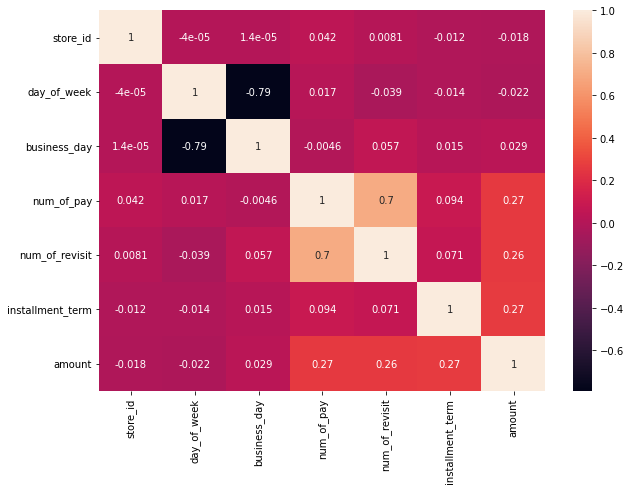

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
sns.heatmap(daily_corr, annot=True)

## Modeling을 위해 Month 단위로 resampling¶


In [46]:
df_day.head(3)

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.00000,0,NaN,기타 미용업,12571.42857
2016-06-02,0,3,1,7,3.00000,0,NaN,기타 미용업,40571.42857
2016-06-03,0,4,1,3,2.00000,0,NaN,기타 미용업,18142.85714


In [47]:
def resample_month(frame_day):
    sum_cols = ['num_of_pay', 'num_of_revisit', 'installment_term', 'amount']

    df_monthly = pd.DataFrame()

    for i in frame_day.store_id.unique():
        df_set = frame_day[frame_day.store_id == i]
        
        # nan값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), end=(df_set.index[0] - relativedelta(months=1)))
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), end=(df_set.index[-1] + relativedelta(months=1)))
        df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)

        df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
        df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1

        tot_day = df_set[df_set.amount != 0].day_of_week.resample(rule='m').count().rename('real_tot_day')
        business = df_set[df_set.amount != 0].business_day.resample(rule='m').sum().rename('real_business_day')

        business = business.drop([business.index[0], business.index[-1]], axis=0)
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)

        df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()], axis=1)

        df.insert(0, 'store_id', i)
        df.insert(6, 'region', df_set.region.values[0])
        df.insert(7, 'type_of_business', df_set.type_of_business.values[0])

        df_monthly = pd.concat([df_monthly, df], axis=0)
   
    return df_monthly

In [48]:
%%time
df_month = resample_month(df_day)

CPU times: user 49.4 s, sys: 566 ms, total: 50 s
Wall time: 45.4 s


In [49]:
df_month.isnull().sum()

store_id                 0
real_tot_day             0
real_business_day        0
num_of_pay               0
num_of_revisit           0
installment_term         0
region               20900
type_of_business     36048
amount                   0
dtype: int64

In [50]:
print("rate of 'region' :" , df_month.region.isnull().sum() / len(df_month))
print("rate of 'type_of_business' :" , df_month.type_of_business.isnull().sum() / len(df_month))

rate of 'region' : 0.34310104243618156
rate of 'type_of_business' : 0.5917754247722236


In [51]:
df_month = df_month.drop(['region', 'type_of_business'], axis=1)
df_month.isnull().sum()

store_id             0
real_tot_day         0
real_business_day    0
num_of_pay           0
num_of_revisit       0
installment_term     0
amount               0
dtype: int64

In [52]:
print(df_month.shape)
df_month.head()

(60915, 7)


,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,amount
2016-06-30,0,25,17.00000,145.00000,77.00000,13.00000,747000.00000
2016-07-31,0,26,16.00000,178.00000,105.00000,24.00000,1005000.00000
2016-08-31,0,24,16.00000,171.00000,97.00000,69.00000,871571.42857
2016-09-30,0,25,19.00000,160.00000,103.00000,15.00000,897857.14286
2016-10-31,0,26,16.00000,167.00000,115.00000,9.00000,835428.57143


# Step2. EDA